In [20]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from math import cos, sin

In [103]:
m = 10
J=0.01
M = np.matrix([[m,0,0],[0,m,0],[0,0,J]])
C = 0
d = 0
R = np.zeros((2, 2))
g=9.8
v_init = np.matrix([[0.1], [0.1]])
# u=np.zeros(8)#
# u=[f_xfl,f_yfl, f_xfr , f_yfr , f_xrl , f_ylr , f_xrr , f_yrr]
# u=np.array(u)
N = 100
print(M)
# v_init=cp.Variable(2)
u=cp.Variable((N,8))


[[10.    0.    0.  ]
 [ 0.   10.    0.  ]
 [ 0.    0.    0.01]]


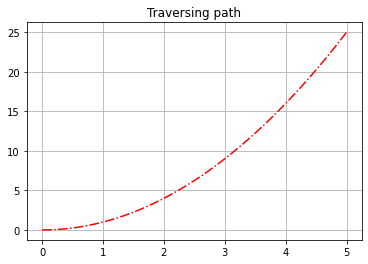

In [104]:
# PATH gen
x = np.linspace(0, 5, N).reshape(-1, 1)
path = np.hstack((x, np.power(x, 2))).T

plt.figure()
plt.plot(path[0, :], path[1, :], "r-.")
plt.grid()
plt.title("Traversing path")
plt.show()
s=np.zeros((N,2))


In [115]:
def get_bar(thetha,i):
#     thetha_bar = []
#     for i in range(1, N):
#         thetha_bar.append((thetha[:, i] + thetha[:, i-1])/2)
#     thetha_bar = np.array(thetha_bar).reshape(1, -1)
    return (thetha[i] + thetha[i-1])/2
def get_R(angle,Wf,w,L):
    return np.matrix([[cos(angle),-sin(angle),cos(angle),-sin(angle),cos(angle),-sin(angle),cos(angle),-sin(angle)],
                      [sin(angle),cos(angle),sin(angle),cos(angle),sin(angle),cos(angle),sin(angle),cos(angle)],
                      [(1-Wf)*L,-w/2,(1-Wf)*L,w/2,-Wf*L,-w/2,-Wf*L,w/2]])

[[ 1.  -0.   1.  -0.   1.  -0.   1.  -0. ]
 [ 0.   1.   0.   1.   0.   1.   0.   1. ]
 [ 1.  -0.5  1.   0.5 -1.  -0.5 -1.   0.5]]


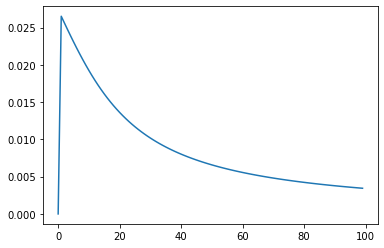

In [132]:
L=2
w=1
Wf=0.5
T=[]
q=np.zeros((N,3))#X,Y,THETA
R=np.zeros((N,3,8))
d_theta=np.zeros(N)
theta=[]
a=cp.Variable(N)
b=cp.Variable(N)
b_dot=cp.Variable(N)

for i in range(N):
    T.append(i)
    temp_x=path[0,i]
    temp_y=path[1,i]
    if temp_y!=0:
        angle=np.arctan(temp_x/temp_y)*(3.14/180)
    else:
        angle=0
    q[i,0]=temp_x
    q[i,1]=temp_y
    q[i,2]=angle
    s[i,0]=temp_x
    s[i,1]=temp_y
    theta.append(angle)
    R[i,:,:]=get_R(angle,Wf,w,L)
    theta_dot=get_bar(theta,i)
# #     print(theta_dot)
#     b[i]=theta_dot**2
#     a[i]=get_bar(b,i)
#     b_dot[i]=2*a[i]*theta_dot
#     try:
#         d_theta[i]=theta[-1]-theta[-2]
#     except:pass
# print(q)
theta=np.array(theta)
print(R[0,:,:])
for i in range(N):
    try:
        d_theta[i]=theta[0][i+1]-theta[0][i]
    except:pass
T=np.array(T)
plt.plot(T,theta)

In [157]:
cost=0
for i in range (N):
    try:
        b_theta=b[i]+([theta[i],theta[i+1]]-theta[i]@((b[i+1]-b[i])/(theta[i+1]-theta[i])))
    except:
        b_theta=b[i]
    cost+=(b_theta)
#     num=get_bar(theta,i)
#     try:
#         denom=cp.sqrt(b[i])+cp.sqrt(b[i+1])
#     except:
# #         denom=cp.sqrt(b[i])
#         pass
#     cost+=(num/denom)

objective=cp.Minimize(2*cost)#30
constraints=[b>=0]
print(b[0],d_theta[0])
# u=[f_xfl,f_yfl, f_xfr , f_yfr , f_xrl , f_ylr , f_xrr , f_yrr]
constraints.append(cp.norm(u[:,0]-u[:,1],2)<=(0.5*Wf*m*g))
constraints.append(cp.norm(u[:,2]-u[:,3],2)<=(0.5*Wf*m*g))
constraints.append(cp.norm(u[:,4]-u[:,5],2)<=(0.5*(1-Wf)*m*g))
constraints.append(cp.norm(u[:,6]-u[:,7],2)<=(0.5*(1-Wf)*m*g))
# s_bar_1 = (cp.diff(s.T[0,:], k=1)/d_theta).T
# print(cp.norm(s).shape)
for i in range(N):
    if i>0:
        constraints.append(b[i]-b[i-1]==2*a[i]*d_theta[i])#34
    else:
        constraints.append(b[i]<=(cp.norm(v_init,2)*d_theta[i])/cp.norm(s[1]-s[0],2)**2)#33
    try:
        theta_tilda=0.5*(theta[i-1]+theta[0][i])
    except:
#         print(theta)
        theta_tilda=0.5*(theta[i])
        pass
    R_tilda=get_R(theta_tilda*(3.14/180),Wf,w,L)
    s_theta=s[i]
#     print("----->",(thetha[i] ))
# #     s_bar_1 = (cp.diff(s.T, k=1)/dthetha).T
#     print((s[i]-s[i-1]),get_bar(thetha,i))
#     s_dash
    if theta_tilda!=0:
        s_dash=(q[i]-q[i-1])/theta_tilda
        m_tilda=(M@q[i].T)@s_dash.T
        constraints.append(R_tilda@u[i]==m_tilda*a[i])#31
    

var58565[0] 0.0


In [158]:
prob=cp.Problem(objective,constraints)
prob.solve()

-9.906642791025391e-12

In [159]:
print(u.value)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 